# [3주차] 기본과제 - DistilBERT로 뉴스 기사 분류 모델 학습하기

- [x] AG_News dataset 준비
	- Huggingface dataset의 `fancyzhx/ag_news`를 load
	- `collate_fn` 함수에 다음 수정사항들을 반영
    - Truncation과 관련된 부분들을 삭제
- [x] Classifier output, loss function, accuracy function 변경
	- 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정
	- 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정
- [x]  학습 결과 report
    - DistilBERT 실습과 같이 매 epoch 마다의 train loss를 출력하고 최종 모델의 test accuracy를 report 첨부
  

In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

DistilBERT pre-training 때 사용한 tokenizer를 불러온다.

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

뉴스 데이터로 Huggingface dataset의 fancyzhx/ag_news를 사용한다.
AG News는 World, Sports, Science, Business, Sci/Tech 5개의 카테고리로 분류된다. label은 1부터 4까지의 숫자로 표현된다.

truncation=False로 설정하여 텍스트를 자르지 않고, 입력 텍스트가 모델의 최대 길이를 초과하면 오류를 발생시킨다.
모델의 최대 길이를 사용하기 위해 max_len을 설정하지 않는다.

In [3]:
# ag_news 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DistilBERT를 사용하기 위해 PyTorch hub에서 제공하는 DistilBERT를 불러온다.

In [4]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

AG News는 4개의 카테고리를 가지고 있으므로 출력 차원을 4로 설정한다.

In [5]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        # 텍스트의 의미를 이해하고 벡터로 변환하는 역할을 한다
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')

        # [CLS] 토큰 분류기 정의
        # 768차원의 입력을 받아 1차원으로 출력하는 선형 레이어 -> 뉴스 카테고리 출력
        # 768은 DistilBERT의 hidden state 크기
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        # DistilBERT는 여러 층의 트랜스포머 레이어로 구성되어 있다
        # last_hidden_state는 마지막 트랜스포머 레이어의 출력값이다
        # 이는 모델이 텍스트를 처리한 최종 문맥 표현(contextual representation)을 담고 있다
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        # (batch_size, 4) 형태의 logits 반환
        return x

model = TextClassifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


마지막 classifier layer를 제외한 나머지 부분을 freeze한다.

In [6]:
for param in model.encoder.parameters():
  param.requires_grad = False

모델의 성능을 평가하기 위해 정확도를 계산하는 함수를 추가한다.

In [7]:
def compute_accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)  # 로짓(logit) 출력

        # argmax 사용하여 가장 높은 확률의 클래스 선택
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

# 모델 성능 평가
def evaluate(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

분류 문제이므로 CrossEntropyLoss 사용한다.

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.



Epoch 1/10
Total Loss: 100.0669
Average Loss: 1.0645
Train Accuracy: 0.7965
Test Accuracy: 0.7974


Epoch 2/10
Total Loss: 69.9823
Average Loss: 0.7445
Train Accuracy: 0.8213
Test Accuracy: 0.8211


Epoch 3/10
Total Loss: 59.4757
Average Loss: 0.6327
Train Accuracy: 0.8327
Test Accuracy: 0.8421


Epoch 4/10
Total Loss: 53.9770
Average Loss: 0.5742
Train Accuracy: 0.8297
Test Accuracy: 0.8474


Epoch 5/10
Total Loss: 51.4097
Average Loss: 0.5469
Train Accuracy: 0.8337
Test Accuracy: 0.8447


Epoch 6/10
Total Loss: 48.9560
Average Loss: 0.5208
Train Accuracy: 0.8453
Test Accuracy: 0.8553


Epoch 7/10
Total Loss: 46.9764
Average Loss: 0.4997
Train Accuracy: 0.8392
Test Accuracy: 0.8342


Epoch 8/10
Total Loss: 47.1030
Average Loss: 0.5011
Train Accuracy: 0.8435
Test Accuracy: 0.8605


Epoch 9/10
Total Loss: 45.6271
Average Loss: 0.4854
Train Accuracy: 0.8443
Test Accuracy: 0.8447


Epoch 10/10
Total Loss: 44.2697
Average Loss: 0.4710
Train Accuracy: 0.8470
Test Accuracy: 0.8447


=== fin

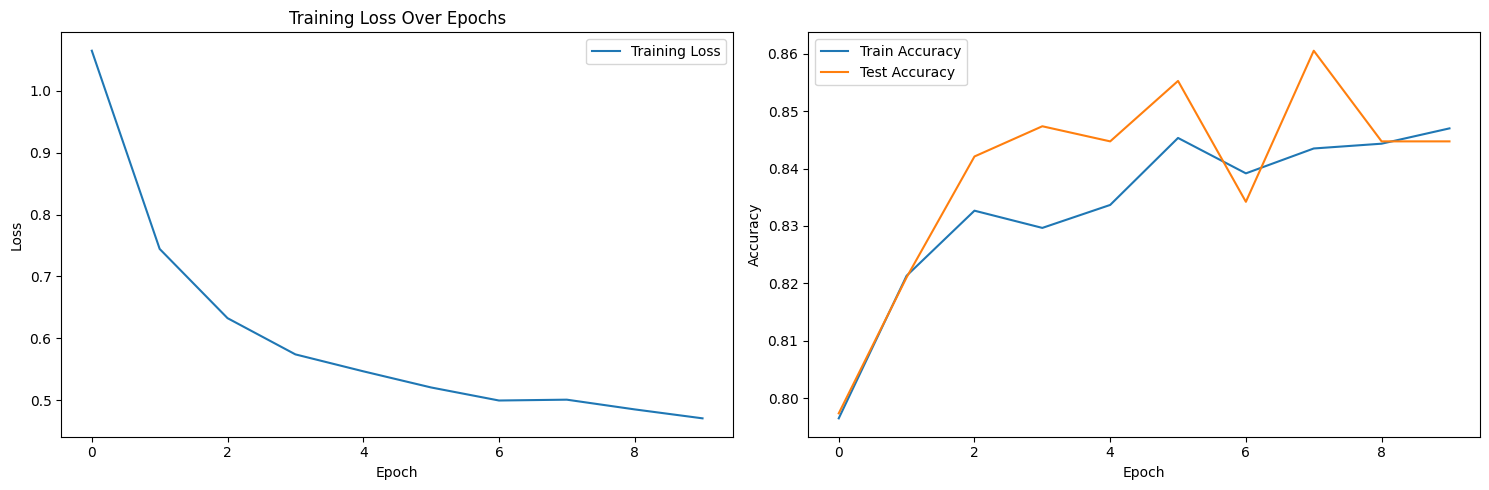

In [8]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
# 분류 문제이므로 CrossEntropyLoss 사용
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

# AG News 클래스 레이블
classes = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

train_losses = []
train_accs = []
test_accs = []

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)

        loss = loss_fn(preds, labels)  # 손실 계산
        total_loss += loss.item()  # loss 누적

        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 에폭마다 정확도 계산
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"\nEpoch {epoch + 1}/{n_epochs}")
    print(f"Total Loss: {total_loss:.4f}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}\n")



train_acc = compute_accuracy(model, train_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"\n=== fine tuning 후 모델 성능 ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
def visualize_predictions(model, dataloader, num_samples):
    model.eval()  # 평가 모드로 설정

    # AG News 클래스 레이블
    classes = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }

    with torch.no_grad():
        # 데이터로더에서 배치 하나를 가져온다
        texts, labels = next(iter(dataloader))
        texts, labels = texts.to('cuda'), labels.to('cuda')

        # 예측 수행
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)

        # num_samples 개수만큼 결과 출력
        print("\n=== 예측 결과 ===")
        for idx in range(min(num_samples, len(texts))):
            print(f"\n샘플 {idx+1}")
            print(f"예측 클래스: {classes[predicted[idx].item()]}")
            print(f"실제 클래스: {classes[labels[idx].item()]}")
            print(f"예측 결과: {'정답' if predicted[idx] == labels[idx] else '오답'}")
            print("-" * 50)

# 예측 결과 확인
visualize_predictions(model, test_loader, 10)


=== 예측 결과 ===

샘플 1
예측 클래스: Business
실제 클래스: Business
예측 결과: 정답
--------------------------------------------------

샘플 2
예측 클래스: Sports
실제 클래스: Sci/Tech
예측 결과: 오답
--------------------------------------------------

샘플 3
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 4
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 5
예측 클래스: Business
실제 클래스: Sci/Tech
예측 결과: 오답
--------------------------------------------------

샘플 6
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 7
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 8
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 9
예측 클래스: Sci/Tech
실제 클래스: Sci/Tech
예측 결과: 정답
--------------------------------------------------

샘플 10
예측 클래스: Business
실제 클래스: Sci/Tech
예측 결과: 오답
---------------------------